In [1]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
#from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation, TimeLimit 
from gymnasium.wrappers.frame_stack import FrameStack
#from gymnasium.wrappers.vector import VectorizeTransformObservation, RecordEpisodeStatistics
from ale_py.vector_env import AtariVectorEnv
from collections import deque
import os
import matplotlib.pyplot as plt
import cProfile, pstats
import torch.jit as jit
from stable_baselines3.common.vec_env import VecFrameStack
import pathlib

In [2]:
class ClipRewardRaw(gym.Wrapper):
   def __init__(self, env, lb, ub):
      gym.Wrapper.__init__(self, env)
      self.episode_score = 0.0
      self.lower_bound = lb
      self.upper_bound = ub
      
   def reset(self, **kwargs):
      obs, info = super().reset(**kwargs)
      self.episode_score = 0.0
      return obs, info
   
   def step(self, action):
      obs, reward, terminated, truncated, info = super().step(action)
      self.episode_score += reward
      if reward > 0:
         clipped_reward = min(self.upper_bound, reward)
      elif reward < 0:
         clipped_reward = max(self.lower_bound, reward)
      else:
         clipped_reward = 0.0
      if terminated or truncated:
         info['score'] = self.episode_score
      return obs, clipped_reward, terminated, truncated, info

class AutoFire(gym.Wrapper):
   def __init__(self, env):
      gym.Wrapper.__init__(self, env)

   def reset(self, **kwargs):
      obs, info = super().reset(**kwargs)
      super().step(1)
      return obs, info
   
   def step(self, action):
      lives_before = self.env.unwrapped.ale.lives()
      state, reward, terminated, truncated, info = super().step(action)
      if info['lives'] < lives_before and not terminated and not truncated:
         super().step(1)
      return state, reward, terminated, truncated, info


In [3]:
def make_env(game):
   def make():
      env = gym.make('ALE/' + game + '-v5', frameskip=1, repeat_action_probability=0.0) 
      env = ClipRewardRaw(env, -1, 1)
      env = AtariPreprocessing(env, noop_max=30, frame_skip=4, terminal_on_life_loss=False, screen_size=84, grayscale_obs=True, scale_obs=False)
      env = FrameStackObservation(env, stack_size=4)
      env = AutoFire(env)
      env = TimeLimit(env, max_episode_steps=18000)
      return env
   return make   

In [ ]:
# gym.register_envs(ale_py)
GAME = "kangaroo"
# # envs = gym.vector.AsyncVectorEnv([make_env(GAME) for i in range(8)])
# envs = gym.make_vec("ALE/" + GAME + "-v5", num_envs=8, vectorization_mode='async', 
#             frameskip=1,
#             repeat_action_probability=0.0,
#             wrappers=(#lambda e:ClipRewardRaw(e, -1, 1), 
#                       lambda e:AtariPreprocessing(e, noop_max=30, frame_skip=4, terminal_on_life_loss=False, screen_size=84, grayscale_obs=True, scale_obs=False), 
#                       lambda e:FrameStackObservation(e, stack_size=4, ),
#                      #  AutoFire, 
#                       lambda e:TimeLimit(e, max_episode_steps=18000)))
# # envs = VecFrameStack(envs, 4)
# envs = RecordEpisodeStatistics(envs)

# # observations, infos = envs.reset()
# # episode_over = False
# # while not episode_over:
# #     action = envs.action_space.sample()  # agent policy that uses the observation and info
# #     observation, reward, terminated, truncated, info = envs.step(action)
# #     episode_over = terminated.any() or truncated.any()
# # envs.close()
# # print(info)
envs = AtariVectorEnv(
    # Required parameters
    game=GAME,
    num_envs=8,
    batch_size=0,
    num_threads=0,
    thread_affinity_offset=0,
    max_num_frames_per_episode=108000,
    repeat_action_probability=0.0,
    full_action_space=False,
    continuous=False,
    continuous_action_threshold=0.5,
    # Preprocessing values
    img_height=84,
    img_width=84,
    stack_num=4,
    frameskip=4,
    maxpool=True,
    noop_max=30,
    episodic_life=False,
    life_loss_info=False,
    reward_clipping=False,
    use_fire_reset=True,
)
eval_env = AtariVectorEnv(
# Required parameters
game=GAME,
num_envs=8,
batch_size=0,
num_threads=0,
thread_affinity_offset=0,
max_num_frames_per_episode=108000,
repeat_action_probability=0.0,
full_action_space=False,
continuous=False,
continuous_action_threshold=0.5,
# Preprocessing values
img_height=84,
img_width=84,
stack_num=4,
frameskip=4,
maxpool=True,
noop_max=30,
episodic_life=False,
life_loss_info=False,
reward_clipping=False,
use_fire_reset=True,
)
#envs = FrameStack(envs, 4)
# envs = RecordEpisodeStatistics(envs)
# observations, _ = envs.reset()
# actions = envs.action_space.sample()
# observations, rewards, terminations, truncations, infos = envs.step(actions)
# actions = envs.action_space.sample()
# observations, rewards, terminations, truncations, infos = envs.step(actions)
# actions = envs.action_space.sample()
# observations, rewards, terminations, truncations, infos = envs.step(actions)
# actions = envs.action_space.sample()
# observations, rewards, terminations, truncations, infos = envs.step(actions)
# print(observations)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = os.path.join('.\models', f'{GAME}-model_double.pt')
best_model_save_path = os.path.join('.\models', f'{GAME}-model_double-BEST.pt')
torch.backends.cudnn.benchmark = True
scaler = torch.amp.GradScaler('cuda')

In [5]:
REPLAY_MEMORY_SIZE = 1000000
BATCH_SIZE = 32
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_EVALUATION = 0.001
FINAL_EXPLORATION_FRAME = 1000000
DISCOUNT_FACTOR = 0.99
UPDATE_FREQUENCY = 15000
REPLAY_START_SIZE = 55000
IN_DIMENSIONS = 4
LEARNING_RATE = 0.00025
GRADIENT_MOMENTUM = 0.95
SQUARED_GRADIENT_MOMENTRUM = 0.95
MIN_SQUARED_GRADIENT = 0.0001
TRAINING_LENGTH = 50000000
EPOCH_LENGTH = 25000
LOG_INTERVAL = 25000
SAVE_FREQUENCY = 5000000
ENV_NUMBER = 8
TRAINING_PER_STEP = 2
EVALUATION_FREQUENCY = 250000

In [6]:
class QNetwork(nn.Module):
   def __init__(self, in_dimensions: int, action_num: int):
      super(QNetwork, self).__init__()
      self.in_dimensions = in_dimensions
      self.action_num = action_num
      self.conv1 = nn.Conv2d(in_channels=self.in_dimensions, out_channels=32, kernel_size=8, stride=4)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
      self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
      # self.fc2 = nn.Linear(in_features=512, out_features=self.action_num)
      self.fc2 = nn.Linear(in_features=512, out_features=action_num, bias=False)
      self.shared_bias = nn.Parameter(torch.zeros(1))

   def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      # x = x.view(x.size(0), -1)
      x = x.contiguous().view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      # x = self.fc2(x)
      q = self.fc2(x) + self.shared_bias
      return q


In [7]:
# Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'over'])

# class ReplayBuffer():
#    def __init__(self):
#       self.buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

#    def append(self, state, action, reward, next_state, over):
#       for i in range(ENV_NUMBER):
#          transition = Transition(state[i], action[i], reward[i], next_state[i], over[i])
#          self.buffer.append(transition)
   
#    def sample(self):
#       indexes = np.random.randint(0, len(self.buffer), size=BATCH_SIZE)
#       states, actions, rewards, next_states, overs = zip(*[self.buffer[idx] for idx in indexes])
#       states = torch.stack(states, dim=0).float().div(255.0).to(device)
#       actions = torch.stack(actions, dim=0)
#       rewards = torch.stack(rewards, dim=0)
#       next_states = torch.stack(next_states, dim=0).float().div(255.0).to(device)
#       overs = torch.stack(overs, dim=0)
#       return states, actions, rewards, next_states, overs

class ReplayBuffer():
   def __init__(self):
      C,H,W = 4, 84, 84
      self.capacity= REPLAY_MEMORY_SIZE
      self.pos     = 0
      self.full    = False

      folder = pathlib.Path('replay_mmap')
      # folder.mkdir(exist_ok=True)

      def make(name, dtype, shape):
         path = folder / f'{name}.dat'
         return np.memmap(path, mode='w+', dtype=dtype, shape=shape)

      # self.states  = torch.empty((REPLAY_MEMORY_SIZE, C, H, W), dtype=torch.uint8, pin_memory=False)
      # self.actions = torch.empty((REPLAY_MEMORY_SIZE,), dtype=torch.int64, pin_memory=True)
      # self.rewards = torch.empty((REPLAY_MEMORY_SIZE,), dtype=torch.float32, pin_memory=True)
      # self.next_states = torch.empty((REPLAY_MEMORY_SIZE, C, H, W), dtype=torch.uint8, pin_memory=False)
      # self.overs   = torch.empty((REPLAY_MEMORY_SIZE,), dtype=torch.uint8, pin_memory=True)

      # self.infos = [None]*REPLAY_MEMORY_SIZE

      self._states_np = make('states', np.uint8, (REPLAY_MEMORY_SIZE, C, H, W))
      self._new_states_np = make('new_state', np.uint8, (REPLAY_MEMORY_SIZE, C, H, W))
      self._actions_np = make('actions', np.int64, (REPLAY_MEMORY_SIZE,))
      self._rewards_np = make('rewards', np.float32, (REPLAY_MEMORY_SIZE,))
      self._overs_np = make('overs', np.uint8, (REPLAY_MEMORY_SIZE,))
      
      self.states = torch.as_tensor(self._states_np, device='cpu')  # sharing the buffer
      self.next_states = torch.as_tensor(self._new_states_np, device='cpu')
      self.actions = torch.as_tensor(self._actions_np, device=device)
      self.rewards = torch.as_tensor(self._rewards_np, device=device)
      self.overs = torch.as_tensor(self._overs_np, device=device)

      # self._states_np = np.memmap(path / 'states.dat', mode='w+', dtype=np)

   def append(self, state, action, reward, next_state, over, episode_start):
      for k in range(ENV_NUMBER):
         if not episode_start[k]:
            i = self.pos
            self.states[i].copy_(state[k])
            self.actions[i] = action[k]
            self.rewards[i] = reward[k]
            self.next_states[i].copy_(next_state[k])
            self.overs[i] = over[k]
            # self.infos.append(info)
            self.pos = (i+1)%REPLAY_MEMORY_SIZE
            self.full = self.full or self.pos==0
            # self.states[self.pos].copy_(next_state[k])

   def sample(self):
      size = self.capacity if self.full else self.pos
      indexes = torch.randint(size, (BATCH_SIZE,))
      states = self.states.index_select(0, indexes).float().div(255.0).to(device, non_blocking=True, memory_format=torch.channels_last)
      next_states = self.next_states.index_select(0, indexes).float().div(255.0).to(device, non_blocking=True, memory_format=torch.channels_last)
      # actions = self.actions.index_select(0, indexes).pin_memory().to(device, non_blocking=True)
      # rewards = self.rewards.index_select(0, indexes).pin_memory().to(device, non_blocking=True)
      # overs   = self.overs.index_select(0, indexes).pin_memory().to(device, non_blocking=True)
      indexes = indexes.to(device)
      actions = self.actions.index_select(0, indexes)
      rewards = self.rewards.index_select(0, indexes)
      overs   = self.overs.index_select(0, indexes)

      return states, actions, rewards, next_states, overs, self.pos

In [8]:
class DQNAgent():
   def __init__(self, env, current_state, buffer: 'ReplayBuffer', model: 'QNetwork', target_model: 'QNetwork', optimizer: torch.optim.RMSprop):
      self.env = env
      self.current_state = current_state
      self.replay_memory = buffer
      self.model = model
      self.target_model = target_model
      self.optimizer = optimizer
      self.frames_history   = []      # x-axis (frame count)
      self.avg100_history   = []      # y-axis (avg reward of last 100 eps)
      self.reward_window = deque(maxlen=100)
      self.episode_reward = np.zeros(ENV_NUMBER)
      self.episode_start = np.zeros(ENV_NUMBER)
      self.print_cycle = 0
      self.best_average = -100000000000

   def select_action(self, epsilon, state):
      # pick action with epsilon-greedy policy
      if np.random.rand() <= epsilon:
         action = self.env.action_space.sample()
      else:
         self.model.eval()
         state = state.float().div(255.0).to(device)
         # state = state.unsqueeze(0).to(device)
         with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            with torch.no_grad():
                  actions = self.model(state)
                  action = torch.argmax(actions, dim=1)
                  action = action.cpu().numpy()
            self.model.train()
         #state = state.squeeze(0).to(device)
      return action

   def learn(self):
      states_tensor, actions_tensor, rewards_tensor, next_states_tensor, overs_tensor, pos = self.replay_memory.sample()
      # if self.print_cycle % 1000 == 0:
      #    print(pos)
      with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
         q_values = self.model(states_tensor)
         q_s_a = q_values.gather(1, actions_tensor.unsqueeze(1))
         # calulcate return
         with torch.no_grad():
            next_online_values = self.model(next_states_tensor)
            actions_argmax = torch.argmax(next_online_values, dim=1) 
            # next_q_values = self.target_model(next_states_tensor)
            # max_nextvalues = next_q_values.max(dim=1).values.unsqueeze(1)
            # print(rewards_tensor.shape, overs_tensor.shape, max_nextvalues.shape)
            # print(overs_tensor.unsqueeze(1))
            # print(rewards_tensor)
            next_q_values = self.target_model(next_states_tensor)
            q_argmax = next_q_values.gather(1, actions_argmax.unsqueeze(1))
            y = rewards_tensor.unsqueeze(1) + (1-overs_tensor.unsqueeze(1))*DISCOUNT_FACTOR*q_argmax
            y = y.to(q_s_a.dtype) 
         # calculate loss and gradient and move weights according to it
         loss = F.mse_loss(y, q_s_a, reduction='mean')
         # loss = F.smooth_l1_loss(y, q_s_a)
      self.optimizer.zero_grad()
      # loss.backward()
      # self.optimizer.step()
      scaler.scale(loss).backward()
      # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
      scaler.step(self.optimizer)
      # self.optimizer.zero_grad(set_to_none=True)
      scaler.update()
      return loss.item()

   def q_learning(self, state, epsilon, frame):
      # select action and do step in env
      self.print_cycle = (self.print_cycle+1) % 1000
      action = self.select_action(epsilon, state)
      self.env.send(action)

      # sample from buffer and extract values for action pair
      losses = np.zeros(TRAINING_PER_STEP)
      for i in range(TRAINING_PER_STEP):
         losses[i] = self.learn()
      # self.optimizer.zero_grad()
      # # loss.backward()
      # # self.optimizer.step()
      # scaler.scale(loss).backward()
      # scaler.step(self.optimizer)
      # scaler.update()

      next_state, reward, terminated, truncated, info = self.env.recv()
      self.episode_reward = np.add(self.episode_reward, reward)
      reward = np.clip(reward, -1, 1)
      # over = terminated or truncated
      over = np.empty((ENV_NUMBER))
      for i in range(ENV_NUMBER):
         over[i] = terminated[i] or truncated[i]

      #state = torch.from_numpy(state).to(device)
      next_state = torch.from_numpy(next_state)#.to(device)
      action = torch.from_numpy(action)#.to(device)
      reward = torch.from_numpy(reward)#.to(device)
      over = torch.from_numpy(over)#.to(device)

      # store the transition in buffer
      # transition = Transition(state, action, reward, next_state, over, info)
      self.replay_memory.append(state, action, reward, next_state, over, self.episode_start)

      return losses, next_state, over, info

   def evaluate(self):
      obs, _ = eval_env.reset()
      self.model.eval()
      episode_rewards = np.zeros(ENV_NUMBER)
      episodes = 0
      frame_num = 0
      max_reward = 0
      cum_reward = 0
      while frame_num <= 500000:
         frame_num += ENV_NUMBER
         obs = torch.from_numpy(obs).float().div(255.0).to(device)
         if np.random.rand() <= EPSILON_EVALUATION:
            action = eval_env.action_space.sample()
         else:
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
               with torch.no_grad():
                  actions = self.model(obs)
                  action = torch.argmax(actions, dim=1)
                  action = action.cpu().numpy()
         obs, rew, ter, trun, info = eval_env.step(action)
         episode_rewards = np.add(episode_rewards, rew)
         over = np.empty((ENV_NUMBER))
         for i in range(ENV_NUMBER):
            over[i] = ter[i] or trun[i]
         if over.any():
            for i in range(len(over)):
               if over[i]:
                  episodes += 1
                  cum_reward += episode_rewards[i]
                  if episode_rewards[i] > max_reward:
                     max_reward = episode_rewards[i]
                  episode_rewards[i] = 0
      print(f'Average: {cum_reward/episodes}, Max: {max_reward}')
      if (cum_reward/episodes) > self.best_average:
         self.best_average = cum_reward/episodes
         torch.save(self.model.state_dict(), best_model_save_path)
      self.model.train()

   def train(self):
      frame = 0
      count = 0
      losses = np.zeros(TRAINING_PER_STEP)
      episodes = 0
      epsilon = EPSILON_START
      # self.current_state, info = self.env.reset()
      self.current_state = torch.from_numpy(self.current_state)#.to(device)
      # self.current_state = torch.from_numpy(self.current_state).float().div(255.0).to(device)
      checkpoints = [LOG_INTERVAL*(x+1) for x in range(int(TRAINING_LENGTH/LOG_INTERVAL))]

      while frame < TRAINING_LENGTH:
         frame += ENV_NUMBER
         count += 1

         # fill replay buffer with start samples
         if frame <= REPLAY_START_SIZE:
            action = self.env.action_space.sample()
            next_state, reward, terminated, truncated, info = self.env.step(action)
            self.episode_reward = np.add(self.episode_reward, reward)
            reward = np.clip(reward, -1, 1)
            over = np.empty((ENV_NUMBER))
            for i in range(ENV_NUMBER):
               over[i] = terminated[i] or truncated[i]
            # over = [terminated[i] or truncated[i] for i in range(ENV_NUMBER)]
            #episode_reward += reward

            next_state = torch.from_numpy(next_state)#.to(device)
            action = torch.from_numpy(action)#.to(device)
            reward = torch.from_numpy(reward)#.to(device)
            over = torch.tensor(over, dtype=torch.uint8)

            # transition = Transition(self.current_state, action, reward, next_state, over, info)
            self.replay_memory.append(self.current_state, action, reward, next_state, over, self.episode_start)
            self.current_state = next_state
            self.episode_start = over
            # self.current_state = self.current_state.float().div(255.0).to(device)
         
         else:
            epsilon = max(EPSILON_END, EPSILON_START - (frame-REPLAY_START_SIZE)/FINAL_EXPLORATION_FRAME)
            losses, next_state, over, info = self.q_learning(self.current_state, epsilon, frame)
            self.current_state = next_state
            self.episode_start = over
            # self.current_state = self.current_state.float().div(255.0).to(device)
            
         # reset if game is over
         if over.any():
            for i in range(len(over)):
               if over[i]:
                  self.reward_window.append(self.episode_reward[i])
                  self.episode_reward[i] = 0
            if frame >= checkpoints[0]:
               average_score = np.mean(self.reward_window)
               self.frames_history.append(frame)
               self.avg100_history.append(average_score)
               print(f"frame {frame:>8d} | avg_100_eps {average_score:6.2f} | losses {losses}")
               checkpoints.pop(0)
            episodes += 1
            # self.current_state, _ = self.env.reset()
            # self.current_state = torch.from_numpy(self.current_state).to(device)
            # self.current_state = torch.from_numpy(self.current_state).float().div(255.0).to(device)

         # periodically update target network weights
         if count % UPDATE_FREQUENCY == 0:
            self.target_model.load_state_dict(self.model.state_dict())

         if frame % SAVE_FREQUENCY == 0:
            torch.save(self.model.state_dict(), model_save_path)

         if frame % EVALUATION_FREQUENCY == 0:
            self.evaluate()
         
      return self.frames_history, self.avg100_history


In [9]:
action_num = int(envs.single_action_space.n)
# action_num = 3
model = QNetwork(IN_DIMENSIONS, action_num).to(device)
#sample = torch.randn(1, 4, 84, 84, device="cuda")
#model = torch.jit.trace(model, sample)
target_model = QNetwork(IN_DIMENSIONS, action_num).to(device)
#target_model = torch.jit.trace(target_model, sample)
target_model.load_state_dict(model.state_dict())
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, alpha=SQUARED_GRADIENT_MOMENTRUM, momentum=0.0, eps=MIN_SQUARED_GRADIENT, centered=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=6.25e-5, betas=(0.9, 0.999), eps=1.5e-4)
replay_memory = ReplayBuffer()
torch.optim.RMSprop
current_state, _ = envs.reset(seed=0)
agent = DQNAgent(envs, current_state, replay_memory, model, target_model, optimizer)
# profiler = cProfile.Profile()
# profiler.enable()
frames_history, avg100_history = agent.train()
# profiler.disable()
# stats = pstats.Stats(profiler).strip_dirs()
# stats.sort_stats("cumulative").print_stats()


frame    25016 | avg_100_eps 227.04 | losses [0. 0.]
frame    50000 | avg_100_eps 268.50 | losses [0. 0.]
frame    75008 | avg_100_eps 227.00 | losses [0.05077434 0.00181103]
frame   100296 | avg_100_eps 228.50 | losses [0.02760966 0.00061439]
frame   125184 | avg_100_eps 227.00 | losses [0.0300647  0.07649877]
frame   150112 | avg_100_eps 231.50 | losses [0.03365241 0.00118678]
frame   175096 | avg_100_eps 258.00 | losses [0.03651075 0.02633079]
frame   200704 | avg_100_eps 232.50 | losses [0.03137467 0.00376826]
frame   225392 | avg_100_eps 235.50 | losses [0.00618137 0.02590549]
Average: 333.6559139784946, Max: 900.0
frame   250336 | avg_100_eps 246.50 | losses [0.01853783 0.00626126]
frame   275024 | avg_100_eps 278.00 | losses [0.02209496 0.02635889]
frame   300280 | avg_100_eps 275.00 | losses [0.00531109 0.00379787]
frame   325184 | avg_100_eps 294.50 | losses [0.0013725  0.01177622]
frame   350080 | avg_100_eps 278.00 | losses [0.00167706 0.04079347]
frame   375256 | avg_100_ep

In [10]:
# with open("profile_report.txt", "w") as f:
    # stats = pstats.Stats(profiler, stream=f)
    # stats.strip_dirs()\
        #  .sort_stats("cumulative")\
        #  .print_stats()

In [11]:
# profiler.dump_stats("profile_report.prof")

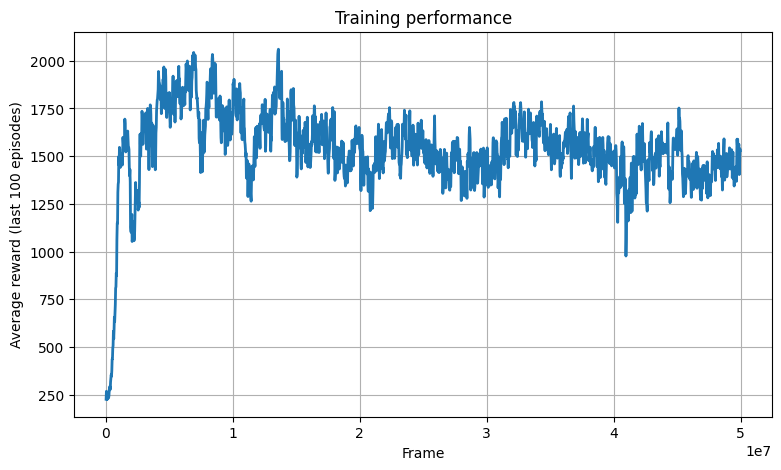

frames logged: [25016, 50000, 75008, 100296, 125184]
avg-100 logged: [np.float64(227.0408163265306), np.float64(268.5), np.float64(227.0), np.float64(228.5), np.float64(227.0)]
1999


In [12]:
plt.figure(figsize=(9, 5))
plt.plot(frames_history, avg100_history, linewidth=2)
plt.xlabel("Frame")
plt.ylabel("Average reward (last 100 episodes)")
plt.title("Training performance")
plt.grid(True)
plt.show()
print("frames logged:", frames_history[:5])
print("avg-100 logged:", avg100_history[:5])
print(len(avg100_history))

In [13]:
np.random.randint(0, 100, size=BATCH_SIZE)

array([17, 54, 67,  1,  0, 11, 92, 34, 78, 19, 64, 31, 16, 79, 73, 13, 43,
       47, 36, 76, 38, 72,  5, 62, 47, 40, 29, 57, 45, 73, 66, 85],
      dtype=int32)

In [14]:
torch.save(agent.model.state_dict(), model_save_path)

In [15]:
best_model = QNetwork(IN_DIMENSIONS, action_num).to(device)
best_model.load_state_dict(torch.load(best_model_save_path, weights_only=True))
best_model.eval()

QNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=False)
)

In [16]:
obs, _ = envs.reset()
agent.model.eval()
episode_reward = np.zeros(ENV_NUMBER)
episodes = 0
max_reward = 0
cum_reward = 0
while episodes < 200:
   obs = torch.from_numpy(obs).float().div(255.0).to(device)
   if np.random.rand() <= EPSILON_EVALUATION:
      action = envs.action_space.sample()
   else:
      with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
         with torch.no_grad():
            actions = best_model(obs)
            action = torch.argmax(actions, dim=1)
            action = action.cpu().numpy()
   obs, rew, ter, trun, info = envs.step(action)
   episode_reward = np.add(episode_reward, rew)
   over = np.empty((ENV_NUMBER))
   for i in range(ENV_NUMBER):
      over[i] = ter[i] or trun[i]
   if over.any():
      for i in range(len(over)):
         if over[i]:
            episodes += 1
            cum_reward += episode_reward[i]
            if episode_reward[i] > max_reward:
               max_reward = episode_reward[i]
            episode_reward[i] = 0
print(cum_reward/200)
print(max_reward)

2547.5
3300.0
